In [1]:
import pandas as pd
import pickle

# Load the dataframe from the pickle file
merged_df = pd.read_pickle('merged_df.pkl')

# Keep only the required columns
merged_df = merged_df[['Date', 'State Name', 'Deaths', 'Predicted Value', 'Month', 'Year']]

In [2]:
merged_df

,Date,State Name,Deaths,Predicted Value,Month,Year
0,2018-01-01,Alabama,56.0,808.0,January,2018.0
48,2018-02-01,Alabama,79.0,822.0,February,2018.0
95,2018-03-01,Alabama,76.0,808.0,March,2018.0
141,2018-04-01,Alabama,66.0,808.0,April,2018.0
187,2018-05-01,Alabama,73.0,811.0,May,2018.0
...,...,...,...,...,...,...
4064,2024-04-01,Wyoming,,132.0,April,2024.0
4071,2024-05-01,Wyoming,,131.0,May,2024.0
4069,2024-06-01,Wyoming,,130.0,June,2024.0
4068,2024-07-01,Wyoming,,127.0,July,2024.0


In [3]:
import pandas as pd

# Load the dataframe from the pickle file
merged_df = pd.read_pickle('merged_df.pkl')

# Keep only the required columns
merged_df = merged_df[['Date', 'State Name', 'Deaths', 'Predicted Value', 'Month', 'Year']]

# Ensure numeric columns are properly converted. Handle potential issues with empty strings.
for col in ['Deaths', 'Predicted Value']:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce') # Convert invalid entries to NaN

# Refill or drop rows with NaN values in numeric columns (optional, based on user requirements)
#merged_df = merged_df.dropna(subset=['Deaths', 'Predicted Value'])

# Calculate z-scores explicitly with debug statements for 'Predicted Value'
merged_df['zscore_predicted_value'] = merged_df.groupby(['State Name'])['Predicted Value'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# Calculate z-scores for 'Deaths' as well
merged_df['zscore_deaths'] = merged_df.groupby(['State Name'])['Deaths'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# Create the variable 'monthseq' based on 'Date'
merged_df = merged_df.sort_values(by=['Date']) # Ensure the DataFrame is sorted by 'Date'
merged_df['monthseq'] = range(1, len(merged_df) + 1) # Assign sequential integers starting from 1

# Save the updated DataFrame to a CSV file
merged_df.to_csv('zscore_dataframe.csv', index=False)

# Display the DataFrame to verify changes
merged_df.head()

,Date,State Name,Deaths,Predicted Value,Month,Year,zscore_predicted_value,zscore_deaths,monthseq
0,2018-01-01,Alabama,56.0,808.0,January,2018.0,-1.022083,-1.339396,1
22,2018-01-01,Michigan,241.0,2717.0,January,2018.0,-0.401928,0.280937,2
13,2018-01-01,Illinois,242.0,2820.0,January,2018.0,-1.214600,-0.800666,3
37,2018-01-01,Pennsylvania,351.0,5472.0,January,2018.0,0.981699,-1.126134,4
19,2018-01-01,Maine,27.0,417.0,January,2018.0,-0.824238,-1.247571,5


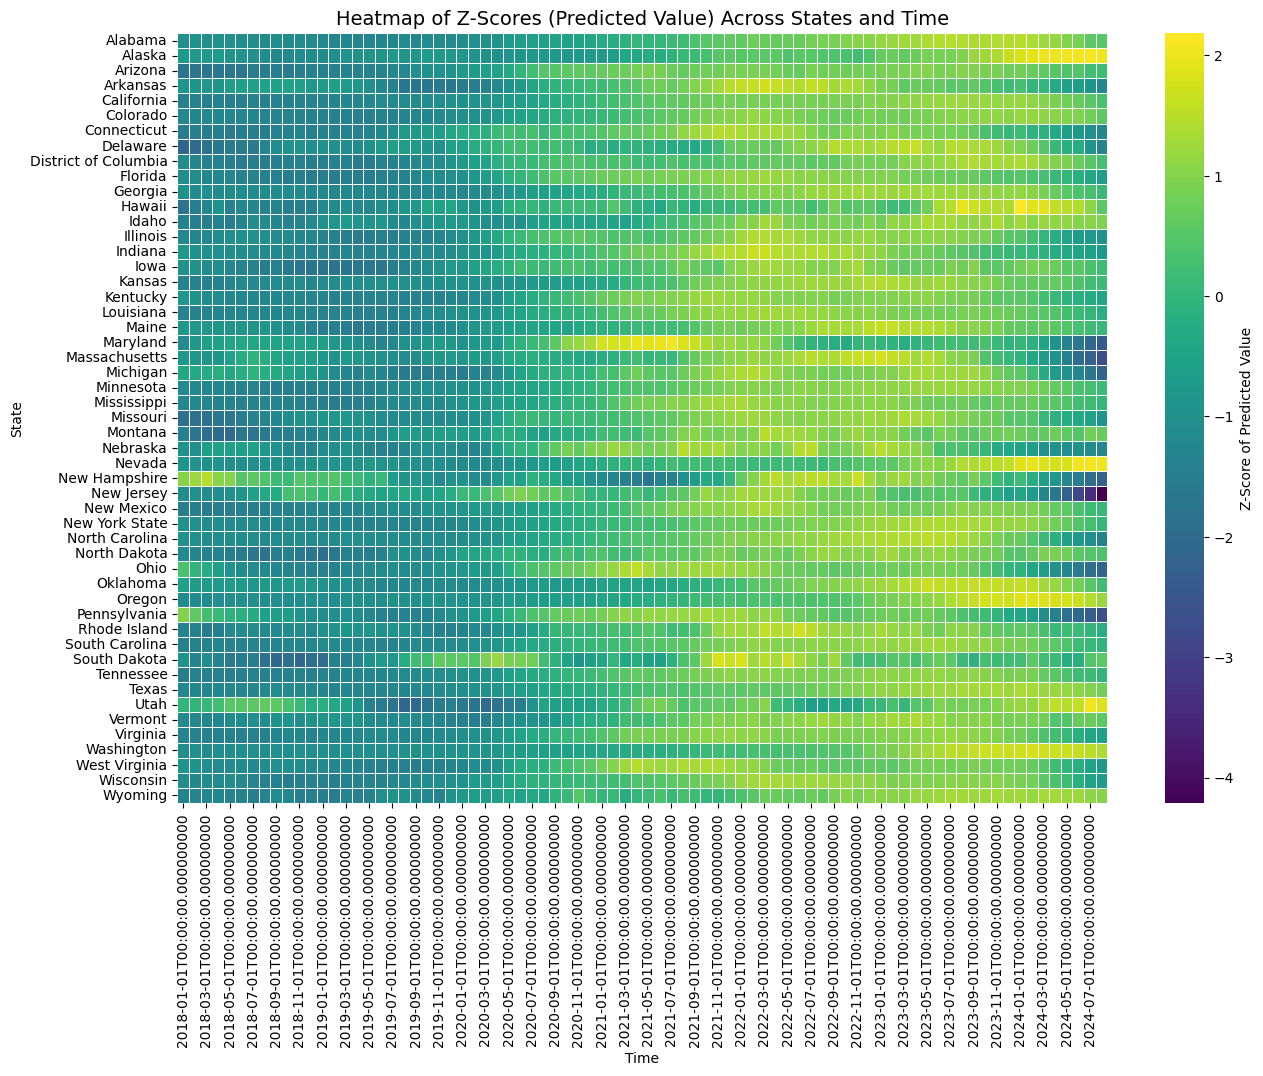

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt 

# Pivot the DataFrame to make 'Date' columns, 'State Name' rows, and 'zscore_predicted_value' values
pivot_df = merged_df.pivot_table(
    index='State Name', 
    columns='Date', 
    values='zscore_predicted_value'
)

plt.figure(figsize=(15, 10))
sns.heatmap(
    pivot_df, 
    cmap='viridis', 
    cbar_kws={'label': 'Z-Score of Predicted Value'}, 
    linewidths=0.5
)
plt.title('Heatmap of Z-Scores (Predicted Value) Across States and Time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

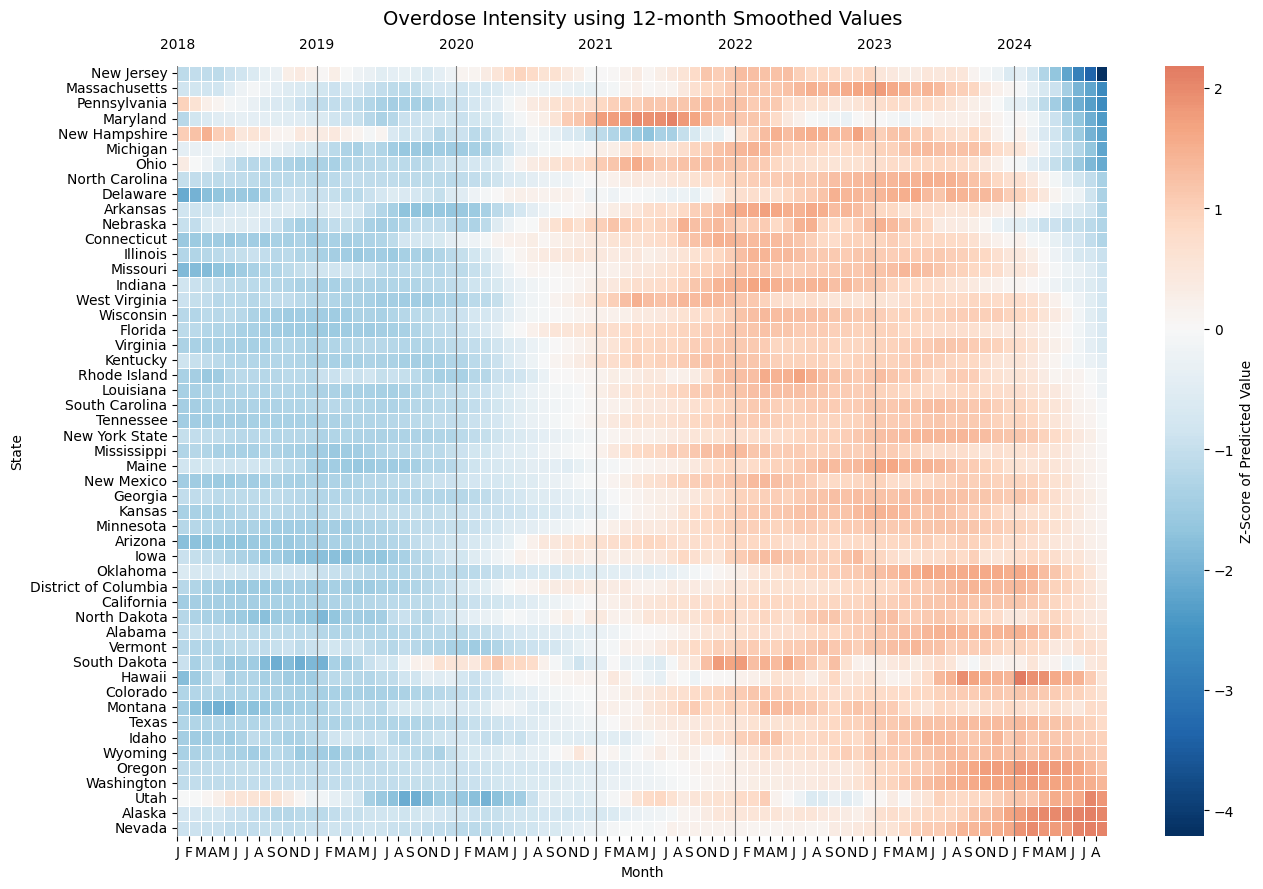

In [5]:
# Identify the most recent date
most_recent_date = merged_df['Date'].max()

# Filter the DataFrame for the most recent date
most_recent_month_df = merged_df[merged_df['Date'] == most_recent_date]

# Sort the states by the z-score of 'Predicted Value' in the most recent month (reversed order)
state_order = most_recent_month_df.sort_values(by='zscore_predicted_value', ascending=True)['State Name']

# Reorder the pivot table's rows by the computed state order
pivot_df_sorted = pivot_df.reindex(state_order)

# Extract unique months for the dataset
months = [pd.to_datetime(date).strftime('%b')[0] for date in pivot_df_sorted.columns]  # Get the first letter of the month

# Create tick positions for mapping
tick_positions = list(range(len(pivot_df_sorted.columns)))

# Identify positions for January of each year and corresponding years
january_positions = [i for i, date in enumerate(pivot_df_sorted.columns) if pd.to_datetime(date).month == 1]
january_years = [pd.to_datetime(pivot_df_sorted.columns[i]).year for i in january_positions]

# Plot the heatmap with 0 as the midpoint of the color ramp
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_df_sorted,
    cmap='RdBu_r',  # Flipped the red-blue colormap
    center=0,       # Make 0 the midpoint of the color ramp
    cbar_kws={'label': 'Z-Score of Predicted Value'},
    linewidths=0.5
)

# Add vertical grey lines and year labels for January of each year
for i, pos in enumerate(january_positions):
    plt.axvline(x=pos, color='grey', linestyle='-', linewidth=0.8)
    plt.text(pos, -1, str(january_years[i]), color='black', fontsize=10, ha='center', va='bottom')  # Add year label

# Set primary x-axis labels without rotation
ax.set_xticks(tick_positions)
ax.set_xticklabels(months, rotation=0)

# Move the title position upwards
plt.title('Overdose Intensity using 12-month Smoothed Values', fontsize=14, pad=30)
plt.xlabel('Month')
plt.ylabel('State')
plt.show()

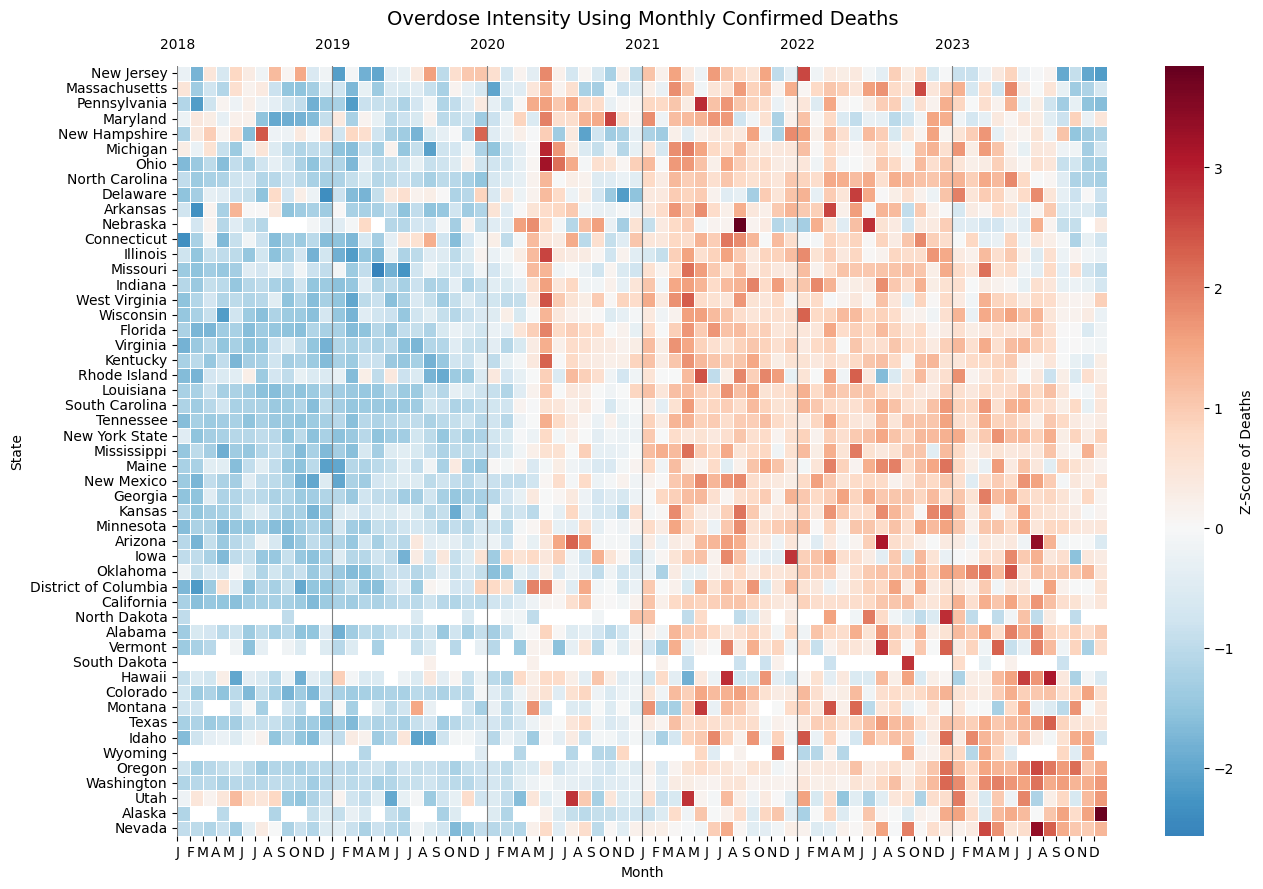

In [6]:
# Sort the data for zscore_deaths in the most recent month based on the same order of states as zscore_predicted_value
state_order_deaths = state_order

# Reorder the pivot table for zscore_deaths by the computed state order
pivot_df_deaths_sorted = merged_df.pivot_table(
    index='State Name',
    columns='Date',
    values='zscore_deaths'
).reindex(state_order_deaths)

# Restructure the monthly labels
months_deaths = [pd.to_datetime(date).strftime('%b')[0] for date in pivot_df_deaths_sorted.columns]
tick_positions_deaths = list(range(len(pivot_df_deaths_sorted.columns)))

# Identify January positions and corresponding years for zscore_deaths
january_positions_deaths = [i for i, date in enumerate(pivot_df_deaths_sorted.columns) if pd.to_datetime(date).month == 1]
january_years_deaths = [pd.to_datetime(pivot_df_deaths_sorted.columns[i]).year for i in january_positions_deaths]

# Plot the heatmap for zscore_deaths
plt.figure(figsize=(15, 10))
ax_deaths = sns.heatmap(
    pivot_df_deaths_sorted,
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label': 'Z-Score of Deaths'},
    linewidths=0.5
)

# Add vertical lines and year labels for January
for i, pos in enumerate(january_positions_deaths):
    plt.axvline(x=pos, color='grey', linestyle='-', linewidth=0.8)
    plt.text(pos, -1, str(january_years_deaths[i]), color='black', fontsize=10, ha='center', va='bottom')

# Set x-axis labels and adjust the title position
ax_deaths.set_xticks(tick_positions_deaths)
ax_deaths.set_xticklabels(months_deaths, rotation=0)

plt.title('Overdose Intensity Using Monthly Confirmed Deaths', fontsize=14, pad=30)
plt.xlabel('Month')
plt.ylabel('State')
plt.show()

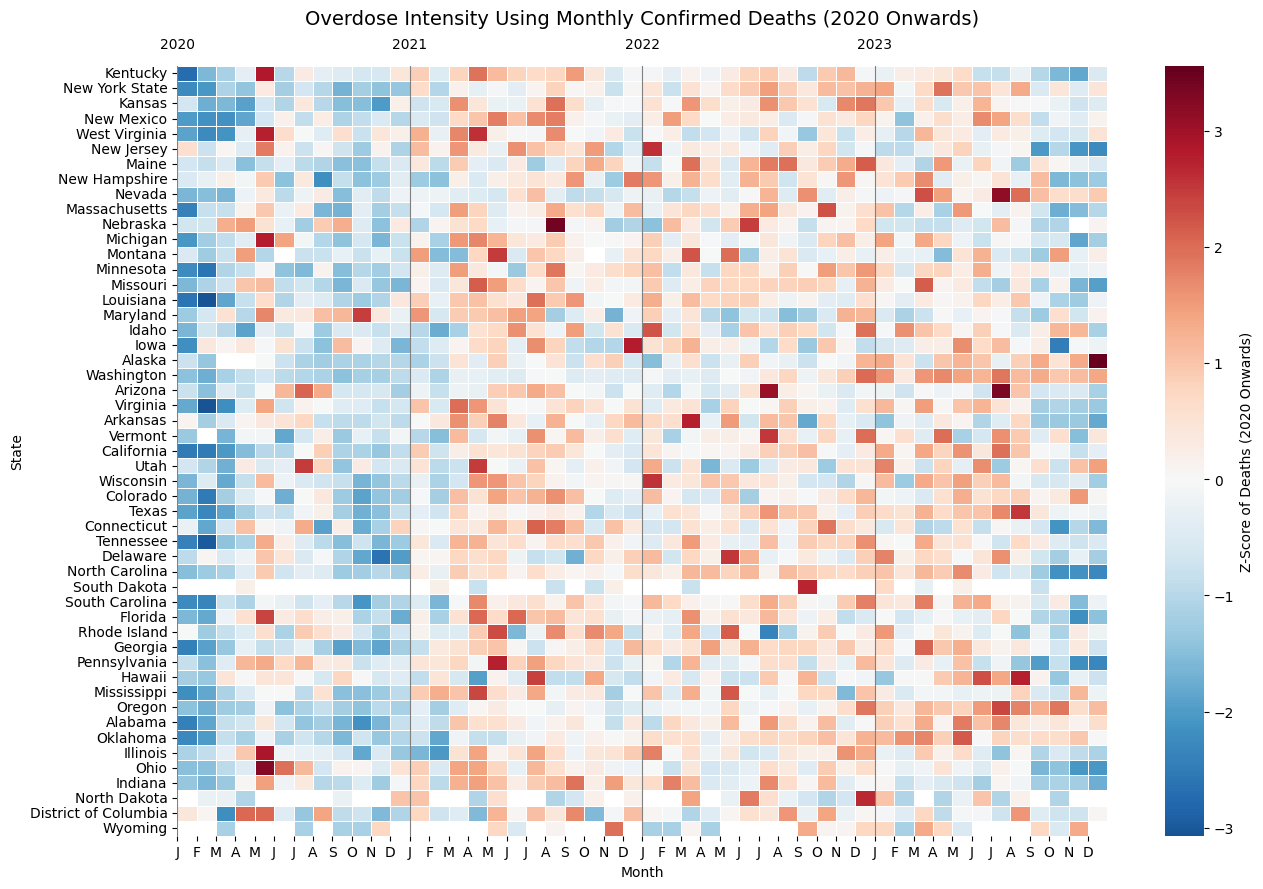

In [7]:
# Filter dataset to include data from January 2020 onwards
merged_df_filtered = merged_df.loc[merged_df['Date'] >= '2020-01-01'].copy()  # Use copy to avoid SettingWithCopyWarning

# Recalculate z-scores for 'Deaths'
merged_df_filtered['zscore_deaths'] = merged_df_filtered.groupby(['State Name'])['Deaths'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# Create a pivot table for 'zscore_deaths'
pivot_df_deaths_filtered = merged_df_filtered.pivot_table(
    index='State Name',
    columns='Date',
    values='zscore_deaths'
)

# Determine state order based on most recent date in the filtered dataset
most_recent_date_filtered = merged_df_filtered['Date'].max()
state_order_filtered = merged_df_filtered[
    merged_df_filtered['Date'] == most_recent_date_filtered
].sort_values(by='zscore_deaths', ascending=True)['State Name']

# Reorder the pivot table by states based on most recent z-score
pivot_df_deaths_sorted_filtered = pivot_df_deaths_filtered.reindex(state_order_filtered)

# Restructure monthly labels for the heatmap
months_filtered = [pd.to_datetime(date).strftime('%b')[0] for date in pivot_df_deaths_sorted_filtered.columns]
tick_positions_filtered = list(range(len(pivot_df_deaths_sorted_filtered.columns)))

# Identify January positions and corresponding years for filtered data
january_positions_filtered = [i for i, date in enumerate(pivot_df_deaths_sorted_filtered.columns) if pd.to_datetime(date).month == 1]
january_years_filtered = [pd.to_datetime(pivot_df_deaths_sorted_filtered.columns[i]).year for i in january_positions_filtered]

# Plot the heatmap for the filtered dataset
plt.figure(figsize=(15, 10))
ax_filtered = sns.heatmap(
    pivot_df_deaths_sorted_filtered,
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label': 'Z-Score of Deaths (2020 Onwards)'},
    linewidths=0.5
)

# Add vertical lines and year labels for January of each year
for i, pos in enumerate(january_positions_filtered):
    plt.axvline(x=pos, color='grey', linestyle='-', linewidth=0.8)
    plt.text(pos, -1, str(january_years_filtered[i]), color='black', fontsize=10, ha='center', va='bottom')

# Set x-axis labels and adjust title position
ax_filtered.set_xticks(tick_positions_filtered)
ax_filtered.set_xticklabels(months_filtered, rotation=0)

plt.title('Overdose Intensity Using Monthly Confirmed Deaths (2020 Onwards)', fontsize=14, pad=30)
plt.xlabel('Month')
plt.ylabel('State')
plt.show()

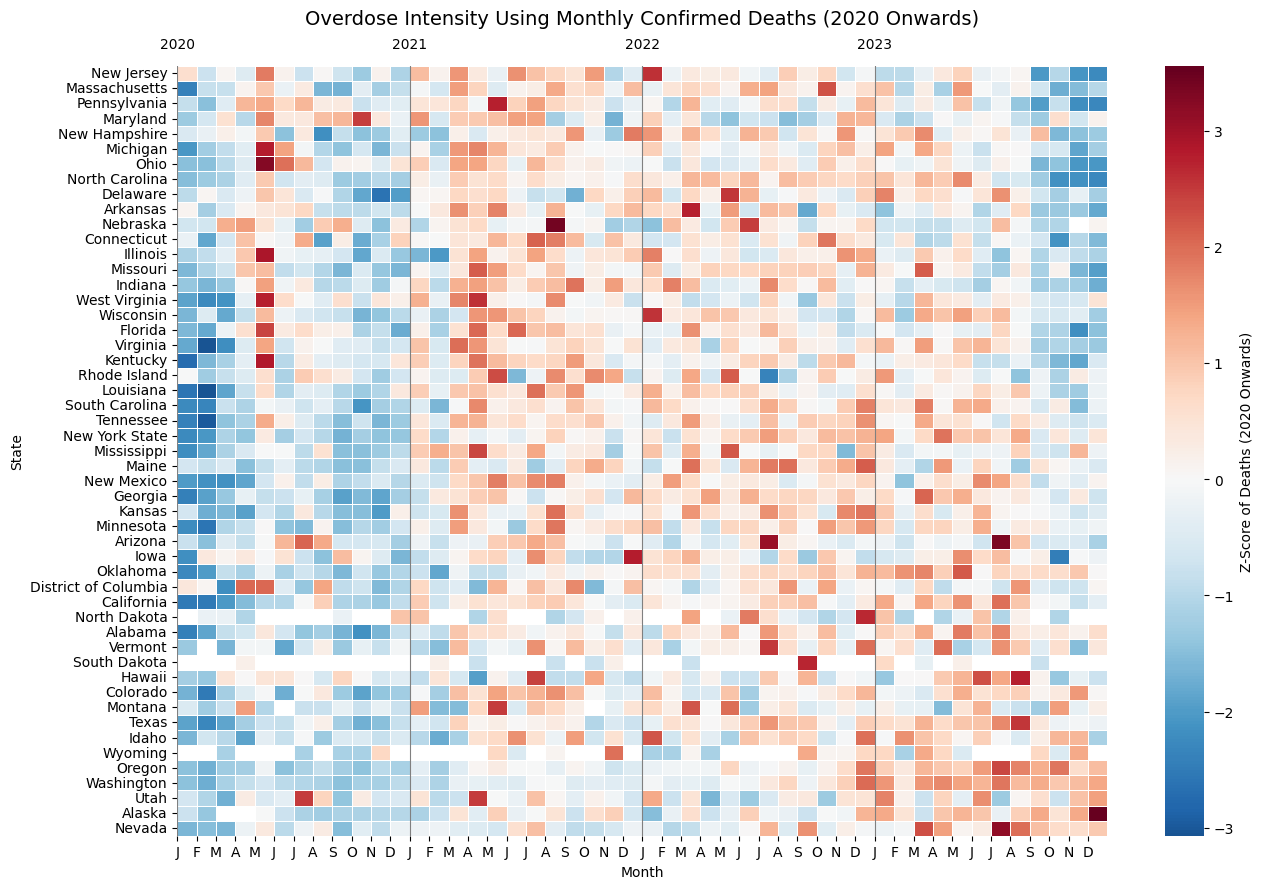

In [8]:
# Filter dataset to include data from January 2020 onwards
merged_df_filtered = merged_df.loc[merged_df['Date'] >= '2020-01-01'].copy()  # Use copy to avoid SettingWithCopyWarning

# Recalculate z-scores for 'Deaths'
merged_df_filtered['zscore_deaths'] = merged_df_filtered.groupby(['State Name'])['Deaths'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# Create a pivot table for 'zscore_deaths'
pivot_df_deaths_filtered = merged_df_filtered.pivot_table(
    index='State Name',
    columns='Date',
    values='zscore_deaths'
)

# Determine state order based on the z-score of 'Predicted Value' in the most recent month (reversed order)
most_recent_date_filtered = merged_df_filtered['Date'].max()
state_order_filtered = merged_df_filtered[
    merged_df_filtered['Date'] == most_recent_date_filtered
].sort_values(by='zscore_predicted_value', ascending=True)['State Name']

# Reorder the pivot table by states based on the z-score of 'Predicted Value'
pivot_df_deaths_sorted_filtered = pivot_df_deaths_filtered.reindex(state_order_filtered)

# Restructure monthly labels for the heatmap
months_filtered = [pd.to_datetime(date).strftime('%b')[0] for date in pivot_df_deaths_sorted_filtered.columns]
tick_positions_filtered = list(range(len(pivot_df_deaths_sorted_filtered.columns)))

# Identify January positions and corresponding years for filtered data
january_positions_filtered = [i for i, date in enumerate(pivot_df_deaths_sorted_filtered.columns) if pd.to_datetime(date).month == 1]
january_years_filtered = [pd.to_datetime(pivot_df_deaths_sorted_filtered.columns[i]).year for i in january_positions_filtered]

# Plot the heatmap for the filtered dataset
plt.figure(figsize=(15, 10))
ax_filtered = sns.heatmap(
    pivot_df_deaths_sorted_filtered,
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label': 'Z-Score of Deaths (2020 Onwards)'},
    linewidths=0.5
)

# Add vertical lines and year labels for January of each year
for i, pos in enumerate(january_positions_filtered):
    plt.axvline(x=pos, color='grey', linestyle='-', linewidth=0.8)
    plt.text(pos, -1, str(january_years_filtered[i]), color='black', fontsize=10, ha='center', va='bottom')

# Set x-axis labels and adjust title position
ax_filtered.set_xticks(tick_positions_filtered)
ax_filtered.set_xticklabels(months_filtered, rotation=0)

plt.title('Overdose Intensity Using Monthly Confirmed Deaths (2020 Onwards)', fontsize=14, pad=30)
plt.xlabel('Month')
plt.ylabel('State')
plt.show()

# Longest consecutive runs

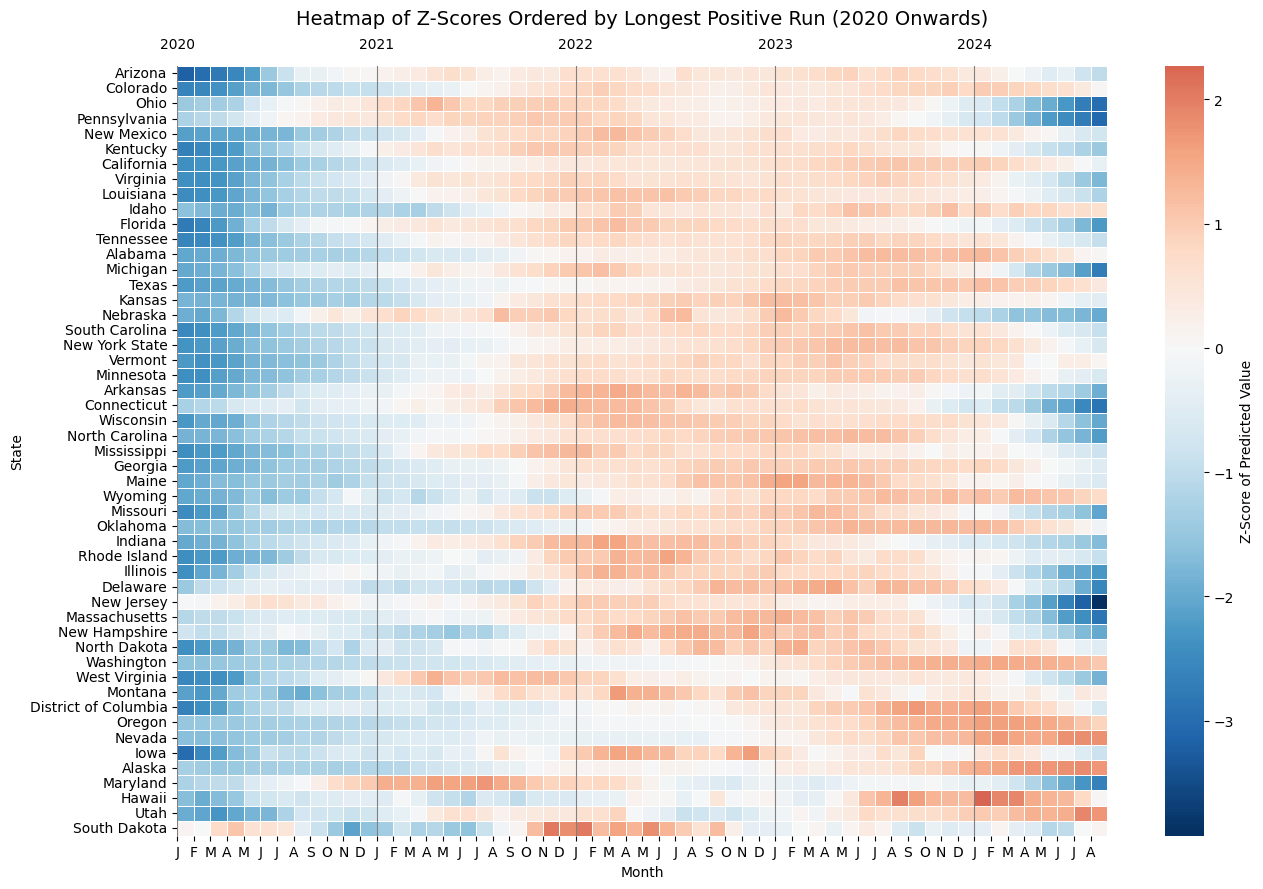

In [9]:
# Recalculate z-scores for 'Predicted Value' for data from 2020 onwards
merged_df_2020_onwards = merged_df.loc[merged_df['Date'] >= '2020-01-01'].copy()

merged_df_2020_onwards['zscore_predicted_value'] = merged_df_2020_onwards.groupby(['State Name'])['Predicted Value'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# Create a pivot table for z-scores of predicted values
pivot_df_filtered = merged_df_2020_onwards.pivot_table(
    index='State Name',
    columns='Date',
    values='zscore_predicted_value'
)

# Calculate the length of the longest run of positive z-scores for each state
def longest_positive_run(series):
    current_run, max_run = 0, 0
    for value in series:
        if value > 0:
            current_run += 1
            max_run = max(max_run, current_run)
        else:
            current_run = 0
    return max_run

# Apply the function to each state's z-score time series
state_longest_runs = pivot_df_filtered.apply(longest_positive_run, axis=1)

# Sort states based on the longest run of positive z-scores
state_order_positive_run = state_longest_runs.sort_values(ascending=False).index

# Reorder pivot table based on this order
pivot_df_positive_sorted = pivot_df_filtered.reindex(state_order_positive_run)

# Restructure the monthly labels
months = [pd.to_datetime(date).strftime('%b')[0] for date in pivot_df_positive_sorted.columns]
tick_positions = list(range(len(pivot_df_positive_sorted.columns)))

# Identify January positions and corresponding years
january_positions = [i for i, date in enumerate(pivot_df_positive_sorted.columns) if pd.to_datetime(date).month == 1]
january_years = [pd.to_datetime(pivot_df_positive_sorted.columns[i]).year for i in january_positions]

# Plot the heatmap
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_df_positive_sorted,
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label': 'Z-Score of Predicted Value'},
    linewidths=0.5
)

# Add vertical grey lines and year labels for January of each year
for i, pos in enumerate(january_positions):
    plt.axvline(x=pos, color='grey', linestyle='-', linewidth=0.8)
    plt.text(pos, -1, str(january_years[i]), color='black', fontsize=10, ha='center', va='bottom')  # Add year label

# Set primary x-axis labels without rotation
ax.set_xticks(tick_positions)
ax.set_xticklabels(months, rotation=0)

# Move the title position upwards
plt.title('Heatmap of Z-Scores Ordered by Longest Positive Run (2020 Onwards)', fontsize=14, pad=30)
plt.xlabel('Month')
plt.ylabel('State')
plt.show()

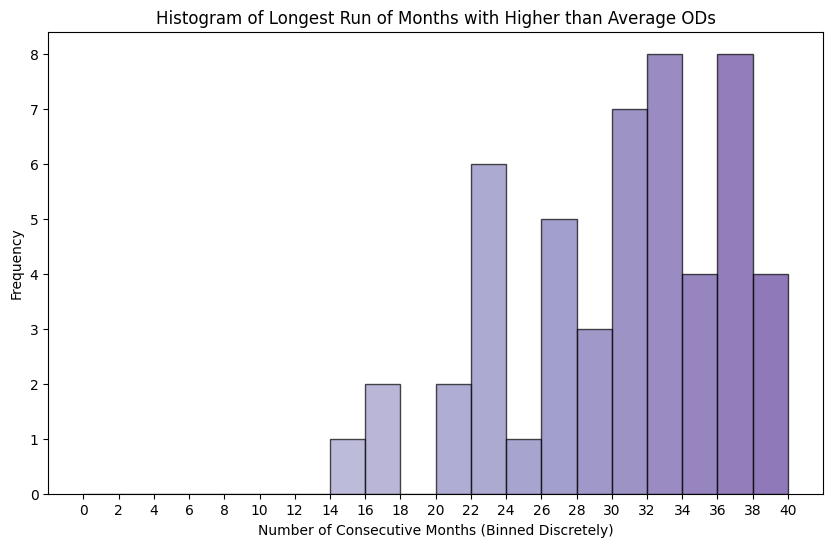

In [10]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Discrete binning for the histogram with fixed intervals
bin_counts, bin_edges = np.histogram(state_longest_runs, bins=np.arange(0, int(state_longest_runs.max()) + 2, 2))
colors = cm.Purples(np.linspace(0.3, 0.8, len(bin_counts)))

plt.figure(figsize=(10, 6))
for idx, count in enumerate(bin_counts):
    plt.bar(
        bin_edges[idx], count, 
        width=bin_edges[idx + 1] - bin_edges[idx], 
        color=colors[idx], edgecolor='black', align='edge', alpha=0.7
    )

plt.title('Histogram of Longest Run of Months with Higher than Average ODs')
plt.xlabel('Number of Consecutive Months (Binned Discretely)')
plt.ylabel('Frequency')
plt.xticks(bin_edges)
plt.show()

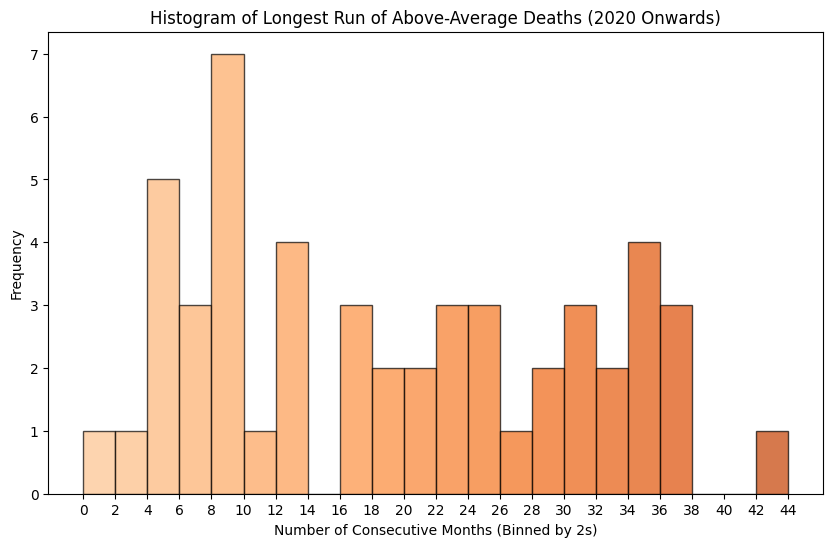

In [11]:
# Filter dataset to include data from January 2020 onwards
merged_df_deaths_2020_onwards = merged_df.loc[merged_df['Date'] >= '2020-01-01'].copy()

# Calculate the length of the longest run of positive z-scores for 'Deaths'
pivot_df_deaths_filtered_2020 = merged_df_deaths_2020_onwards.pivot_table(
    index='State Name',
    columns='Date',
    values='zscore_deaths'
)

# Apply the same function to calculate the longest run of positive z-scores for deaths
state_longest_death_runs = pivot_df_deaths_filtered_2020.apply(longest_positive_run, axis=1)

# Bin discrete intervals for the runs (bin size = 2)
bin_counts, bin_edges = np.histogram(state_longest_death_runs, bins=range(0, int(state_longest_death_runs.max()) + 3, 2))

# Assign colors based on bins using the "Oranges" colormap
colors = cm.Oranges(np.linspace(0.3, 0.8, len(bin_counts)))

# Plot histogram
plt.figure(figsize=(10, 6))
for i in range(len(bin_counts)):
    plt.bar(bin_edges[i], bin_counts[i], width=bin_edges[i + 1] - bin_edges[i], color=colors[i], edgecolor='black', align='edge', alpha=0.7)

plt.title('Histogram of Longest Run of Above-Average Deaths (2020 Onwards)')
plt.xlabel('Number of Consecutive Months (Binned by 2s)')
plt.ylabel('Frequency')
plt.xticks(bin_edges)
plt.show()

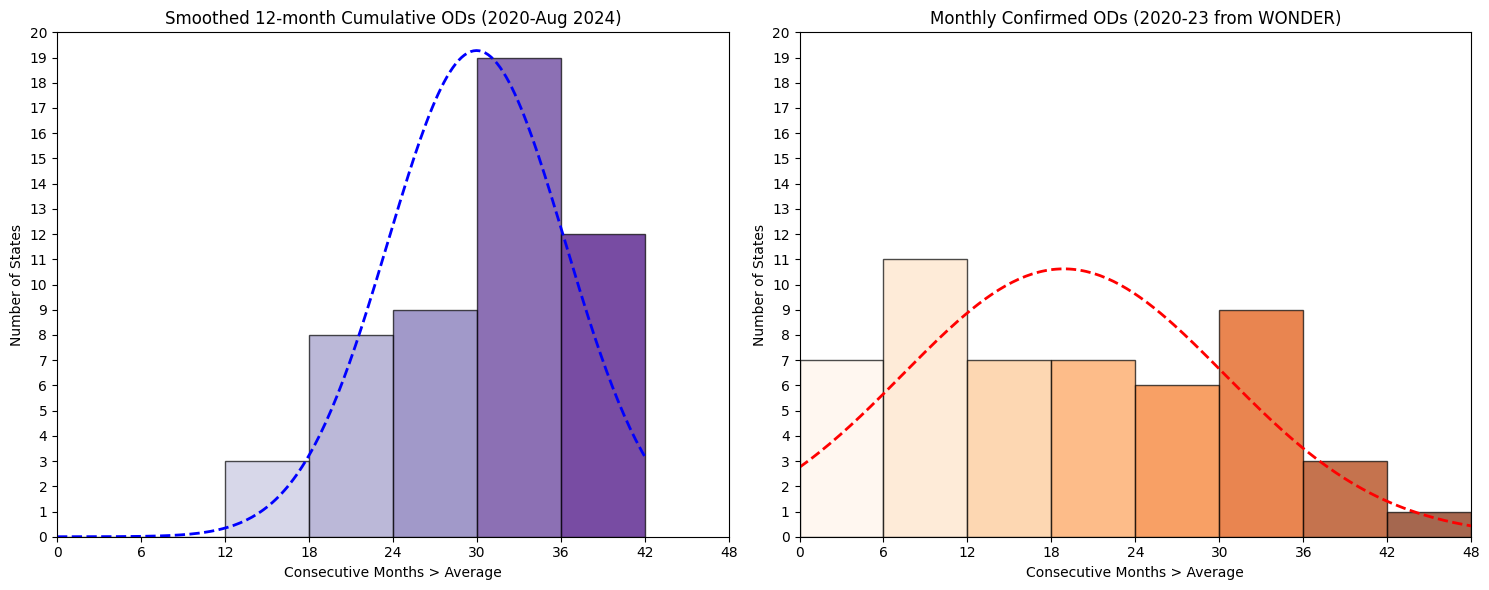

In [12]:
# Create side-by-side histograms ensuring same horizontal tick marks for both
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for longest runs of 'Predicted Value'
bin_counts_predicted, bin_edges_predicted = np.histogram(
    state_longest_runs, bins=range(0, int(state_longest_runs.max()) + 7, 6))
months_run_predicted = (bin_edges_predicted[:-1] + bin_edges_predicted[1:]) / 2
colors_predicted = cm.Purples((months_run_predicted - min(months_run_predicted)) / (max(months_run_predicted) - min(months_run_predicted)))

for i in range(len(bin_counts_predicted)):
    axes[0].bar(bin_edges_predicted[i], bin_counts_predicted[i],
                width=bin_edges_predicted[i + 1] - bin_edges_predicted[i], 
                color=colors_predicted[i], edgecolor='black', align='edge', alpha=0.7)

# Add bell curve to the first histogram
mu_predicted = state_longest_runs.mean()
sigma_predicted = state_longest_runs.std()
x_predicted = np.linspace(bin_edges_predicted[0], bin_edges_predicted[-1], 200)
curve_predicted = len(state_longest_runs) * (bin_edges_predicted[1] - bin_edges_predicted[0]) * \
    (1 / (sigma_predicted * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_predicted - mu_predicted) / sigma_predicted) ** 2)
axes[0].plot(x_predicted, curve_predicted, color='blue', linestyle='--', linewidth=2)

axes[0].set_title('Smoothed 12-month Cumulative ODs (2020-Aug 2024)')
axes[0].set_xlabel('Consecutive Months > Average')
axes[0].set_ylabel('Number of States')

# Histogram for longest runs of 'Deaths'
bin_counts_deaths, bin_edges_deaths = np.histogram(
    state_longest_death_runs, bins=range(0, int(state_longest_death_runs.max()) + 7, 6))
months_run_deaths = (bin_edges_deaths[:-1] + bin_edges_deaths[1:]) / 2
colors_deaths = cm.Oranges((months_run_deaths - min(months_run_deaths)) / (max(months_run_deaths) - min(months_run_deaths)))

for i in range(len(bin_counts_deaths)):
    axes[1].bar(bin_edges_deaths[i], bin_counts_deaths[i],
                width=bin_edges_deaths[i + 1] - bin_edges_deaths[i], 
                color=colors_deaths[i], edgecolor='black', align='edge', alpha=0.7)

# Add bell curve to the second histogram
mu_deaths = state_longest_death_runs.mean()
sigma_deaths = state_longest_death_runs.std()
x_deaths = np.linspace(bin_edges_deaths[0], bin_edges_deaths[-1], 200)
curve_deaths = len(state_longest_death_runs) * (bin_edges_deaths[1] - bin_edges_deaths[0]) * \
    (1 / (sigma_deaths * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_deaths - mu_deaths) / sigma_deaths) ** 2)
axes[1].plot(x_deaths, curve_deaths, color='red', linestyle='--', linewidth=2)

axes[1].set_title('Monthly Confirmed ODs (2020-23 from WONDER)')
axes[1].set_xlabel('Consecutive Months > Average')
axes[1].set_ylabel('Number of States')

# Adjust y-axis to have the same scale and ensure integer tick marks
max_y = max(max(bin_counts_predicted), max(bin_counts_deaths))
for ax in axes:
    ax.set_ylim(0, max_y + 1)
    ax.set_yticks(range(0, max_y + 2))

# Ensure both subplots have the same x-axis tick marks
x_min = min(min(bin_edges_predicted), min(bin_edges_deaths))
x_max = max(max(bin_edges_predicted), max(bin_edges_deaths))
x_ticks = range(x_min, x_max + 1, 6)
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)

plt.tight_layout()
plt.show()

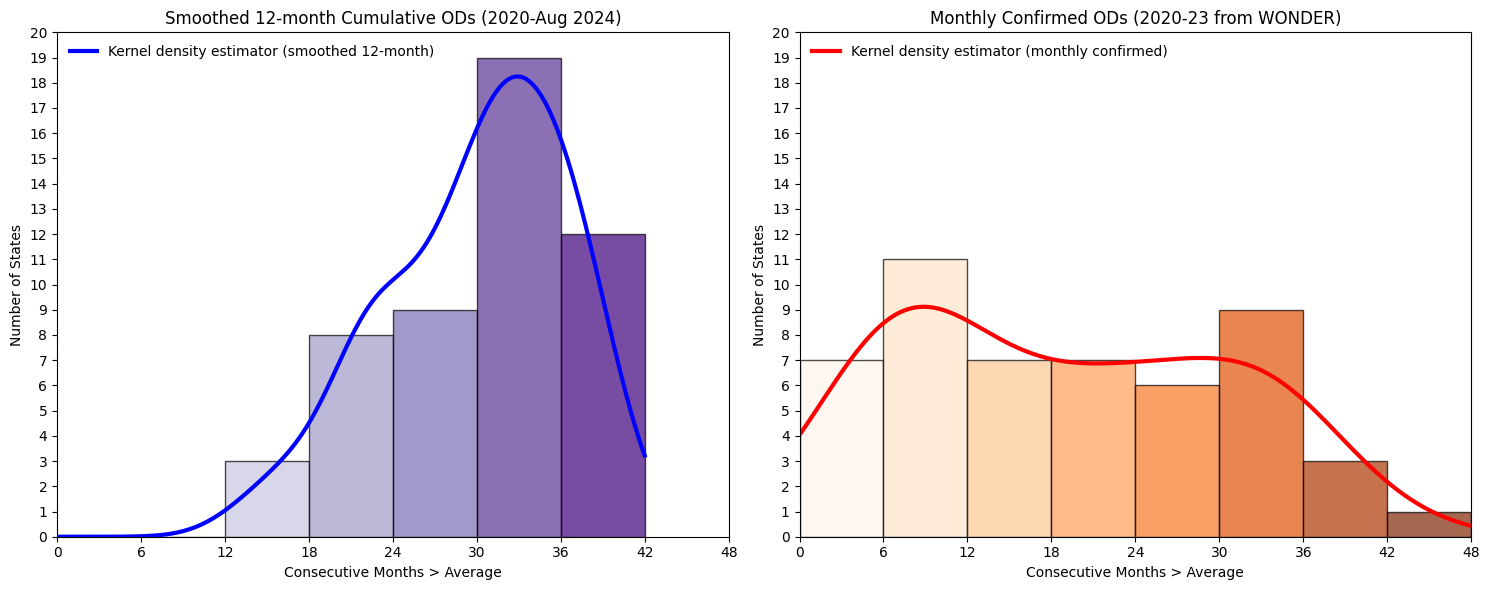

In [13]:
from scipy.stats import gaussian_kde

# Create side-by-side histograms ensuring same horizontal tick marks for both
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for longest runs of 'Predicted Value'
bin_counts_predicted, bin_edges_predicted = np.histogram(
    state_longest_runs, bins=range(0, int(state_longest_runs.max()) + 7, 6))
months_run_predicted = (bin_edges_predicted[:-1] + bin_edges_predicted[1:]) / 2
colors_predicted = cm.Purples((months_run_predicted - min(months_run_predicted)) / (max(months_run_predicted) - min(months_run_predicted)))

for i in range(len(bin_counts_predicted)):
    axes[0].bar(bin_edges_predicted[i], bin_counts_predicted[i],
                width=bin_edges_predicted[i + 1] - bin_edges_predicted[i], 
                color=colors_predicted[i], edgecolor='black', align='edge', alpha=0.7)

# Add KDE line to the first histogram
kde_predicted = gaussian_kde(state_longest_runs)
x_predicted = np.linspace(bin_edges_predicted[0], bin_edges_predicted[-1], 200)
axes[0].plot(x_predicted, kde_predicted(x_predicted) * len(state_longest_runs) * (bin_edges_predicted[1] - bin_edges_predicted[0]),
             color='blue', linestyle='-', linewidth=3, label='Kernel density estimator (smoothed 12-month)')

axes[0].set_title('Smoothed 12-month Cumulative ODs (2020-Aug 2024)')
axes[0].set_xlabel('Consecutive Months > Average')
axes[0].set_ylabel('Number of States')

# Histogram for longest runs of 'Deaths'
bin_counts_deaths, bin_edges_deaths = np.histogram(
    state_longest_death_runs, bins=range(0, int(state_longest_death_runs.max()) + 7, 6))
months_run_deaths = (bin_edges_deaths[:-1] + bin_edges_deaths[1:]) / 2
colors_deaths = cm.Oranges((months_run_deaths - min(months_run_deaths)) / (max(months_run_deaths) - min(months_run_deaths)))

for i in range(len(bin_counts_deaths)):
    axes[1].bar(bin_edges_deaths[i], bin_counts_deaths[i],
                width=bin_edges_deaths[i + 1] - bin_edges_deaths[i], 
                color=colors_deaths[i], edgecolor='black', align='edge', alpha=0.7)

# Add KDE line to the second histogram
kde_deaths = gaussian_kde(state_longest_death_runs)
x_deaths = np.linspace(bin_edges_deaths[0], bin_edges_deaths[-1], 200)
axes[1].plot(x_deaths, kde_deaths(x_deaths) * len(state_longest_death_runs) * (bin_edges_deaths[1] - bin_edges_deaths[0]),
             color='red', linestyle='-', linewidth=3, label='Kernel density estimator (monthly confirmed)')

axes[1].set_title('Monthly Confirmed ODs (2020-23 from WONDER)')
axes[1].set_xlabel('Consecutive Months > Average')
axes[1].set_ylabel('Number of States')

# Adjust y-axis to have the same scale and ensure integer tick marks
max_y = max(max(bin_counts_predicted), max(bin_counts_deaths))
for ax in axes:
    ax.set_ylim(0, max_y + 1)
    ax.set_yticks(range(0, max_y + 2))

# Ensure both subplots have the same x-axis tick marks
x_min = min(min(bin_edges_predicted), min(bin_edges_deaths))
x_max = max(max(bin_edges_predicted), max(bin_edges_deaths))
x_ticks = range(x_min, x_max + 1, 6)
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)

# Add legends in top left without bounding boxes
axes[0].legend(loc='upper left', frameon=False)
axes[1].legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

# Z-score plots

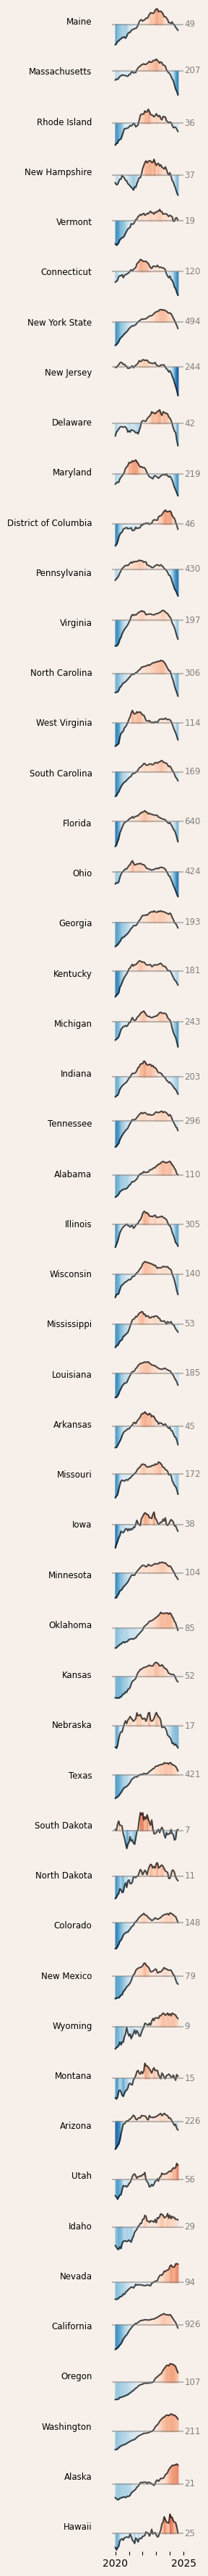

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Load the data
merged_df = pd.read_csv('merged_data.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])  # Ensure 'Date' is a datetime object

# Filter for January 2020 onwards
merged_df = merged_df[merged_df['Date'] >= '2020-01-01']

# Load state centroid data with longitude (mock data structure for this example)
state_centroids = {
    'Alabama': -86.9023, 'Alaska': -152.4044, 'Arizona': -111.0937, 'Arkansas': -92.2880,
    'California': -119.4179, 'Colorado': -105.5506, 'Connecticut': -72.6970, 'Delaware': -75.5277,
    'Florida': -81.5158, 'Georgia': -83.5002, 'Hawaii': -155.5828, 'Idaho': -114.7420,
    'Illinois': -89.3985, 'Indiana': -86.1349, 'Iowa': -93.6091, 'Kansas': -98.4842,
    'Kentucky': -84.2700, 'Louisiana': -91.9623, 'Maine': -69.4455, 'Maryland': -76.6413,
    'Massachusetts': -71.3824, 'Michigan': -85.6024, 'Minnesota': -93.9002, 'Mississippi': -89.6787,
    'Missouri': -92.6179, 'Montana': -110.3626, 'Nebraska': -99.9018, 'Nevada': -116.4194,
    'New Hampshire': -71.5724, 'New Jersey': -74.4057, 'New Mexico': -106.0181, 'New York State': -74.006,
    'North Carolina': -79.0193, 'North Dakota': -100.4659, 'Ohio': -82.7937, 'Oklahoma': -97.5211,
    'Oregon': -120.5542, 'Pennsylvania': -77.1945, 'Rhode Island': -71.4774, 'South Carolina': -81.1637,
    'South Dakota': -99.9018, 'Tennessee': -86.5804, 'Texas': -99.9018, 'Utah': -111.9507,
    'Vermont': -72.5778, 'Virginia': -78.6569, 'Washington': -120.7401, 'West Virginia': -80.7125,
    'Wisconsin': -89.6165, 'Wyoming': -107.3025, 'District of Columbia': -77.033
}

# Add longitude information to merged_df
merged_df['Longitude'] = merged_df['State Name'].map(state_centroids)

# Calculate z-scores for 'Predicted Value' grouped by state
merged_df['zscore_predicted_value'] = merged_df.groupby('State Name')['Predicted Value'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# Calculate average Predicted Value for the entire time period by state
state_avg_predicted_value = merged_df.groupby('State Name')['Predicted Value'].mean()

# Sort states by longitude in descending order (east at the top), excluding "New York"
states_sorted_by_long = merged_df[merged_df['State Name'] != "New York"] \
    [['State Name', 'Longitude']].drop_duplicates() \
    .sort_values(by='Longitude', ascending=False)['State Name']

# Prepare the data for sparklines
months = pd.date_range(merged_df['Date'].min(), merged_df['Date'].max(), freq='MS')
fig, axes = plt.subplots(len(states_sorted_by_long), 1, figsize=(3, len(states_sorted_by_long) * 0.7), sharex=True)  # Adjusted width (narrower)
fig.patch.set_facecolor('#f7f0ea')  # Set background color for the entire figure area

# Generate sparklines for each state
for i, state in enumerate(states_sorted_by_long):
    ax = axes[i] if len(states_sorted_by_long) > 1 else axes  # Single subplot vs multiple
    ax.set_facecolor('#f7f0ea')  # Set background color for each subplot
    state_data = merged_df[merged_df['State Name'] == state]

    # Normalize z-scores to use with colormap
    norm = plt.Normalize(vmin=-4, vmax=4)  # Assuming z-scores range from -4 to 4
    cmap = plt.get_cmap('RdBu_r')  # Blue-Red colormap

    # Add fill between shading and trace line with color
    ax.plot(
        state_data['Date'],
        state_data['zscore_predicted_value'],
        color='black', linewidth=1.5, alpha=0.7  # Thicker black trace line
    )

    for j in range(len(state_data) - 1):
        ax.fill_between(
            state_data['Date'].iloc[j:j+2],
            0,
            state_data['zscore_predicted_value'].iloc[j:j+2],
            color=cmap(norm(state_data['zscore_predicted_value'].iloc[j]))
        )

    # Add average Predicted Value scaled down by 12 near the end of the state's line
    if state in state_avg_predicted_value:
        predicted_value_scaled = state_avg_predicted_value[state] / 12

        ax.text(
            merged_df['Date'].max() + pd.Timedelta(days=180), 0,  # Move further to the right
            f'{predicted_value_scaled:,.0f}',
            color='grey', fontsize=8.5, ha='left', va='center'  # Fixed font size to 8.5
        )

    ax.axhline(c='grey', alpha=0.5)  # Horizontal reference line

    # Remove borders and labels
    ax.set_yticks([])
    ax.set_ylabel(state, rotation=0, fontsize=8.5, labelpad=20, ha='right')  
    plt.setp(ax.spines.values(), visible=False)

    # Remove x-axis ticks for all but the last plot
    if i < len(states_sorted_by_long) - 1:
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust x-axis only for the last subplot
if len(axes) > 1:
    plt.setp(axes[-1].get_xticklabels(), visible=True)
    axes[-1].tick_params(axis='x', rotation=0)

# Set custom tick labels for the bottom plot
full_tick_locs = pd.date_range('2020-01-01', '2025-01-01', freq='YS')
axes[-1].set_xticks(full_tick_locs)
tick_labels = ["2020" if date.year == 2020 else "2025" if date.year == 2025 else "" for date in full_tick_locs]
axes[-1].set_xticklabels(tick_labels)

# Define output path and ensure directory exists
output_path = 'state_sparklines.png'
plt.tight_layout()
plt.savefig(output_path, dpi=500)
plt.show()

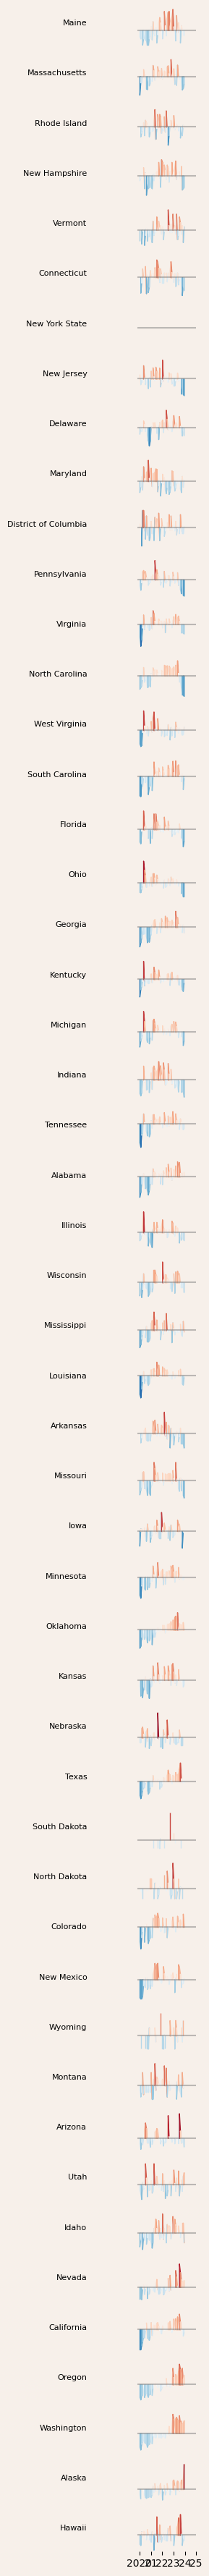

In [15]:
# Adjust the code to use 'Deaths' instead of 'Predicted Value'

# Filter for January 2020 onwards
merged_df = merged_df[merged_df['Date'] >= '2020-01-01']

# Calculate z-scores for 'Deaths' grouped by state
merged_df['zscore_deaths'] = merged_df.groupby('State Name')['Deaths'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# Prepare the sparklines for deaths
fig, axes = plt.subplots(len(states_sorted_by_long), 1, figsize=(3, len(states_sorted_by_long) * 0.7), sharex=True)
fig.patch.set_facecolor('#f7f0ea')

# Generate sparklines for each state using z-scores for deaths
for i, state in enumerate(states_sorted_by_long):
    ax = axes[i] if len(states_sorted_by_long) > 1 else axes
    ax.set_facecolor('#f7f0ea')
    state_data = merged_df[merged_df['State Name'] == state]

    # Normalize z-scores for deaths
    norm = plt.Normalize(vmin=-4, vmax=4)
    cmap = plt.get_cmap('RdBu_r')

    for j in range(len(state_data) - 1):
        ax.fill_between(
            state_data['Date'].iloc[j:j+2],
            0,
            state_data['zscore_deaths'].iloc[j:j+2],
            color=cmap(norm(state_data['zscore_deaths'].iloc[j]))
        )

    ax.axhline(c='grey', alpha=0.5)  # Horizontal reference line

    # Remove borders and labels
    ax.set_yticks([])
    ax.set_ylabel(state, rotation=0, fontsize=8, labelpad=50, ha='right')
    plt.setp(ax.spines.values(), visible=False)

    # Remove x-axis ticks for all but the last plot
    if i < len(states_sorted_by_long) - 1:
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust x-axis only for the last subplot
if len(axes) > 1:
    plt.setp(axes[-1].get_xticklabels(), visible=True)
    axes[-1].tick_params(axis='x', rotation=0)

# Set custom tick labels for the bottom plot
tick_locs = pd.date_range('2020-01-01', '2025-01-01', freq='AS')
axes[-1].set_xticks(tick_locs)
axes[-1].set_xticklabels(["2020", "21", "22", "23", "24", "25"])
axes[-1].tick_params(axis='x', which='both', labelbottom=True)

plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a0b131bb-b3d4-45d7-9b08-dfa85260ae4a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>